In [1]:
#
import warnings 
warnings.filterwarnings("ignore")

# 1D inversion of AEM data over a layered Earth

[![License: CC BY 4.0](https://licensebuttons.net/l/by/4.0/80x15.png)](https://creativecommons.org/licenses/by/4.0/)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import time
import ipywidgets

# SimPEG, discretize/
import discretize
from discretize import utils
from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

# solver 
from simpeg.utils.solver_utils import get_default_solver

In [3]:
Solver = get_default_solver()

## define survey and model parameters

In [4]:
# conductivity values
rho_back = 100

sigma_target = 0.1
sigma_back = 1/rho_back

# target geometry
target_thickness = 40
target_depth = 200 + target_thickness/2 * np.r_[-1, 1]

print(f"target conductances: {sigma_target * target_thickness}")

target conductances: 4.0


In [5]:
# transmitter
tx_height = 30
tx_radius = 10

# receiver times
rx_times = 1e-3 * np.logspace(-1, 1, 30)  # 30 time-channels between 0.1ms and 10ms

In [6]:
def diffusion_distance(sigma, t):
    return 1260 * np.sqrt(t/sigma)

In [7]:
# minimum diffusion distance (max conductivity, earliest time) 
diffusion_distance(sigma_target, rx_times.min())

np.float64(39.844698518121575)

In [8]:
# maximum diffusion distance (background conductivity, latest time)
diffusion_distance(sigma_back, rx_times.max())

np.float64(1260.0)

## create our survey 

In [9]:
rx_z = tdem.receivers.PointMagneticFluxTimeDerivative(
    np.r_[0, 0, tx_height], times=rx_times, orientation="z"
)

src = tdem.sources.CircularLoop(
    location=np.r_[0, 0, tx_height], radius=tx_radius, receiver_list=[rx_z], #waveform=waveform
)

survey = tdem.Survey([src])

## create our true model and data 
- construct a 3 layer model
- run simulation to generate data for background, 3 layer model 

In [10]:
m_true = np.log(np.r_[sigma_back, sigma_target, sigma_back])
thicknesses_true = np.r_[target_depth.min(), target_thickness]
simulation_3layer = tdem.Simulation1DLayered(
    survey=tdem.Survey([src]), thicknesses=thicknesses_true, sigmaMap=maps.ExpMap(nP=3)
)

(440.0, 0.0)

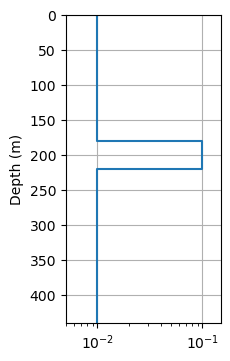

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
plot_1d_layer_model(thicknesses_true, np.exp(m_true), ax=ax)
ax.grid()
ax.set_xlim(0.5*sigma_back, 1.5*sigma_target)
ax.set_ylim([target_depth.max()*2, 0])

In [12]:
relative_error = 0.05
d_background = simulation_3layer.dpred(np.log(sigma_back)*np.ones(3))
d_true = simulation_3layer.dpred(m_true)
d_noisy = d_true + relative_error*np.abs(d_true)*np.random.randn(len(d_true))
dobs = d_noisy

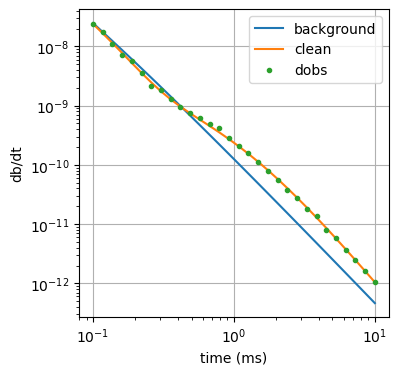

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.loglog(rx_times*1e3, -d_background, label="background")
ax.loglog(rx_times*1e3, -d_true, label="clean")
ax.loglog(rx_times*1e3, -d_noisy, ".", label="dobs")
ax.set_xlabel("time (ms)")
ax.set_ylabel("db/dt")
ax.legend()
ax.grid()

## define a 1D mesh for the inversion

In [15]:
cell_size = 5
layer_thicknesses = np.hstack([[cell_size]*int(300/cell_size), cell_size * np.logspace(0, 1.5, 20)])

In [16]:
# create a mesh with one extra layer so we can regularize the value that goes to "infinite" depth
mesh = discretize.TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], origin="0")

Text(0.5, 0, 'depth (m)')

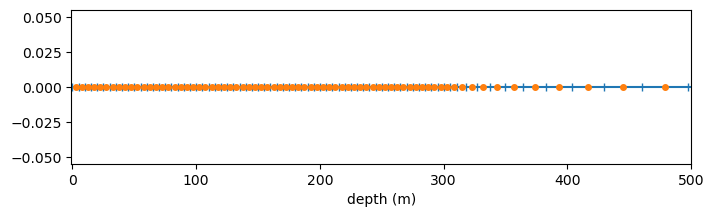

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.plot(mesh.nodes, np.zeros_like(mesh.nodes), "-|")
ax.plot(mesh.cell_centers, np.zeros_like(mesh.cell_centers), "o", ms=4)
ax.set_xlim([-1, 500])
ax.set_xlabel("depth (m)")

define the simulation for the inversion

In [20]:
# Mapping dimensions
simulation = tdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses, sigmaMap=maps.ExpMap(mesh)  # invert for log conductivity
)

# set up the inversion

std = relative_error*np.abs(dobs) + noise_floor

In [33]:
# Creata data object with survey and uncertainties

data_invert = data.Data(survey, dobs=dobs, relative_error=0.05)

In [34]:
# Call to save inversion progress

class SaveInversionProgress(directives.InversionDirective):
    """
    A custom directive to save items of interest during the course of an inversion
    """
    
    def initialize(self):
        """
        This is called when we first start running an inversion
        """
        # initialize an empty dictionary for storing results 
        self.inversion_results = {
            "iteration":[],
            "beta":[],
            "phi_d":[],
            "phi_m":[],
            "phi_m_small":[],
            "phi_m_smooth":[],
            "dpred":[],
            "model":[]
        }

    def endIter(self):
        """
        This is run at the end of every iteration. So here, we just append 
        the new values to our dictionary
        """
        
        # Save the data
        self.inversion_results["iteration"].append(self.opt.iter)
        self.inversion_results["beta"].append(self.invProb.beta)
        self.inversion_results["phi_d"].append(self.invProb.phi_d)
        self.inversion_results["phi_m"].append(self.invProb.phi_m)
        self.inversion_results["dpred"].append(self.invProb.dpred)
        self.inversion_results["model"].append(self.invProb.model)
        
        # grab the components of the regularization and evaluate them here
        # the regularization has a list of objective functions  
        # objfcts = [smallness, smoothness_x, smoothness_z]
        # and the multipliers contain the alpha values
        # multipliers = [alpha_s, alpha_x, alpha_z]
        reg = self.reg.objfcts[0] 
        phi_s = reg.objfcts[0](self.invProb.model) * reg.multipliers[0]
        phi_x = reg.objfcts[1](self.invProb.model) * reg.multipliers[1]
        
        self.inversion_results["phi_m_small"].append(phi_s)
        self.inversion_results["phi_m_smooth"].append(phi_x)

In [42]:
# Function to set up inversions

def setup_inversion(alpha_s=0.1, alpha_x=1): 
    """
    Simple, resable function for setting up inversions with different 
    choices of regularization parameters
    """
    # define misfit and regularization 
    dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_invert)

    # Similar to Sparse but only 2
    reg = regularization.WeightedLeastSquares( 
        mesh, 
        alpha_s=alpha_s, alpha_x=alpha_x, 
        reference_model=np.log(sigma_back),
    )

    opt = optimization.InexactGaussNewton(maxIter=30, tolCG=1e-3)
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
    
    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
    beta_cooling = directives.BetaSchedule(coolingRate=1, coolingFactor=1.5)

    # Options for outputting recovered models and predicted data for each beta.
    save_iteration = SaveInversionProgress()

    # stop the inversion when we reach the target misfit -- here we overfit to explore models
    target_misfit = directives.TargetMisfit(chifact=0.1) #chifact = overfit or not

    # The directives are defined as a list.
    directives_list = [
        starting_beta,
        beta_cooling,
        target_misfit,
        save_iteration,
    ]
    
    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)
    
    return inv, save_iteration

In [56]:
# create the inversion object
#inv, save_iteration = setup_inversion(alpha_s=1/cell_size**2, alpha_x=1)
inv, save_iteration = setup_inversion(alpha_s=10e-3, alpha_x=1)


In [57]:
# Run the inversion
starting_model = np.log(sigma_back)*np.ones(mesh.n_cells)
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.83e+03  2.42e+03  4.95e-32  2.42e+03    4.61e+02      0              
   1  1.89e+03  1.96e+03  6.74e-02  2.09e+03    2.01e+02      0              
   2  1.26e+03  1.66e+03  1.78e-01  1.89e+03    1.86e+02      0   Skip BFGS  
   3  8.39e+02  1.31e+03  3.81e-01  1.63e+03    1.90e+02      0   Skip BFGS  
   4  5.59e+02  8.78e+02  7.29e-01  1.29e+03    1.89e+02      0              
   5  3.73e+02  4.71e+02  1.20e+00  9.18e+02    1.61e+02      0         

In [58]:
def plot_recovered_model(model, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(3, 5))

    plot_1d_layer_model(simulation_3layer.thicknesses, np.exp(m_true), ax=ax, color="k", label="True")
    plot_1d_layer_model(mesh.h[0], np.exp(model), ax=ax, label="Recovered")
    
    ax.set_ylim([450, 0])
    ax.set_xlim(sigma_back*0.5, sigma_target*2)
    ax.grid("both", alpha=0.7)
    ax.legend()
    
    ax.set_xlabel("conductivity (S/m)")

In [59]:
def plot_obs_pred_data(model, dpred, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))

    ax.loglog(rx_times*1e3, -dobs, "ko", label="dobs", ms=4)
    ax.loglog(rx_times*1e3, -dpred, label="Recovered")
    
    ax.legend()
    ax.grid("both", alpha=0.7)
    ax.set_xlabel("time (ms)")
    ax.set_ylabel("db/dt")
    return ax

In [60]:
# model that reaches target misfit
diff_from_target = save_iteration.inversion_results["phi_d"] - survey.nD
iter_target = np.where(diff_from_target == np.max(diff_from_target[diff_from_target < 0]))[0][0]

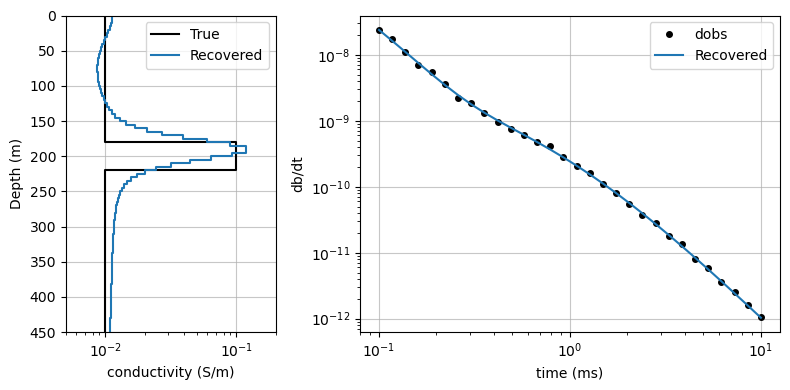

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={"width_ratios":[1, 2]})
plot_recovered_model(save_iteration.inversion_results["model"][iter_target], ax=ax[0])
plot_obs_pred_data(recovered_model, save_iteration.inversion_results["dpred"][iter_target], ax=ax[1])
plt.tight_layout()

In [63]:
def plot_tikhonov_curves(inversion_results, iteration=None, ax=None, log=False):
    if ax is None: 
        fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), layout="constrained")

    ax[0].plot(inversion_results["iteration"], inversion_results["beta"], "-o", ms=4, color="C4")
    ax[0].set_title("$\\beta$")
    ax[0].set_ylabel("$\\beta$")
    if iteration is not None: 
        ax[0].plot(
            inversion_results["iteration"][iteration], inversion_results["beta"][iteration], "s", ms=6, color="k"
        )   
    
    ax[1].plot(inversion_results["iteration"], inversion_results["phi_d"], "-o", ms=4, color="C3")
    ax[1].plot(inversion_results["iteration"], survey.nD*np.ones_like(inversion_results["iteration"]), "--", color="k" )
    ax[1].text(1, survey.nD*2, "$\phi_d^*$")
    ax[1].set_title("$\phi_d$")
    ax[1].set_ylabel("$\phi_d$")
    if iteration is not None: 
        ax[1].plot(
            inversion_results["iteration"][iteration], inversion_results["phi_d"][iteration], "s", ms=6, color="k",
            label=f"$\chi={inversion_results['phi_d'][iteration] / len(rx_times):1.1f}$"
        )
        ax[1].legend()
    
    ax[2].plot(inversion_results["iteration"], inversion_results["phi_m"], "-o", ms=4, label="$\phi_m$")
    ax[2].plot(inversion_results["iteration"], inversion_results["phi_m_small"], "-o", ms=4, label="smallness")
    ax[2].plot(inversion_results["iteration"], inversion_results["phi_m_smooth"], "-o", ms=4, label="smoothness")
    ax[2].set_title("$\phi_m$")
    ax[2].set_ylabel("$\phi_m$")
    ax[2].legend()
    if iteration is not None: 
        ax[2].plot(
            inversion_results["iteration"][iteration], inversion_results["phi_m"][iteration], "s", ms=6, color="k"
        )
        ax[2].plot(
            inversion_results["iteration"][iteration], inversion_results["phi_m_small"][iteration], "s", ms=6, color="k"
        )
        ax[2].plot(
            inversion_results["iteration"][iteration], inversion_results["phi_m_smooth"][iteration], "s", ms=6, color="k"
        )
    
    for a in ax[:3]:
        a.set_xlabel("iteration")
        xticks = inversion_results["iteration"]
        while len(xticks) > 10: 
            xticks = xticks[::2]
        a.set_xticks(xticks)
    
    ax[3].plot(inversion_results["phi_m"], inversion_results["phi_d"],  "-o", ms=4, color="k")
    ax[3].plot(inversion_results["phi_m"], survey.nD*np.ones_like(inversion_results["iteration"]), "--", color="k" )
    ax[3].text(inversion_results["phi_m"][0], survey.nD*2, "$\phi_d^*$")
    ax[3].set_xlabel("$\phi_m$")
    ax[3].set_ylabel("$\phi_d$")
    ax[3].set_title("$\phi_d$ vs. $\phi_m$")
    if iteration is not None: 
        ax[3].plot(
            inversion_results["phi_m"][iteration], inversion_results["phi_d"][iteration], "s", ms=6, color="k"
        )

    if log is True: 
        for a in ax:
            a.set_yscale('log')
        ax[3].set_xscale('log')
    
    # plt.tight_layout()
    return ax

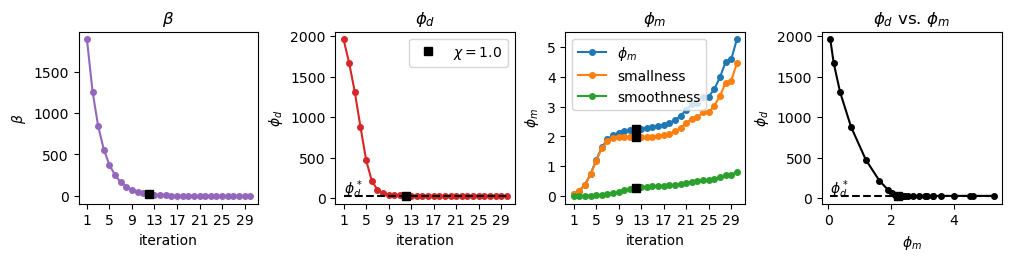

In [64]:
plot_tikhonov_curves(save_iteration.inversion_results, iteration=iter_target, log=False);

In [65]:
def plot_inversion_results_by_iteration(iteration, log=False):
    fig, axd = plt.subplot_mosaic(
        [['a', 'b', 'c', 'd'],
         ['e', 'f', 'f', 'g']],
        figsize=(10, 6), layout="constrained",
        gridspec_kw={"height_ratios": [1, 2]}
    )
    
    ax_tikhonov = plot_tikhonov_curves(
        save_iteration.inversion_results, iteration, ax=[axd[k] for k in ["a", "b", "c", "d"]], log=log
    )
    
    plot_recovered_model(save_iteration.inversion_results["model"][iteration], ax=axd["e"])
    plot_obs_pred_data(recovered_model, save_iteration.inversion_results["dpred"][iteration], ax=axd["f"])

    axd["g"].axis("off")
    # plt.tight_layout()

In [66]:
ipywidgets.interact(
    plot_inversion_results_by_iteration, 
    iteration=ipywidgets.IntSlider(min=0, max=save_iteration.inversion_results["iteration"][-2], value=0)
)

interactive(children=(IntSlider(value=0, description='iteration', max=29), Checkbox(value=False, description='…

<function __main__.plot_inversion_results_by_iteration(iteration, log=False)>